In [2]:
!pip install -q accelerate -U

In [3]:
!pip install -q evaluate

In [4]:
!pip install -q emoji==0.6.0

In [5]:
!pip install -q wordcloud

In [6]:
import pandas as pd
import numpy as np
import torch
from tqdm import tqdm
from transformers import AutoModelForSequenceClassification
from transformers import AutoTokenizer, AutoConfig
from transformers import TrainingArguments, Trainer, EarlyStoppingCallback
from scipy.special import softmax
from datasets import Dataset
import evaluate
from sklearn.model_selection import train_test_split
import os
import random

import nltk
import re
from collections import defaultdict
from wordcloud import STOPWORDS

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

print(torch.__version__)
print(torch.cuda.is_available())

2.0.0+cu117
True


## 데이터 로딩 및 분할

In [7]:
TRAIN = "./data/train.csv"
TEST = "./data/test.csv"
SUBMIT = "./data/sample_submission.csv"

In [8]:
train_data = pd.read_csv(TRAIN)
test_data = pd.read_csv(TEST)
train_data, valid_data = train_test_split(train_data, test_size=0.1, shuffle=True, random_state=42, stratify=train_data['sentiment'])

In [9]:
train_data= train_data.reset_index(drop=True)
valid_data= valid_data.reset_index(drop=True)

## 시드 고정

In [10]:
def seed_everything(seed: int = 33):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)  # type: ignore
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True  # type: ignore
    torch.backends.cudnn.benchmark = False

In [11]:
seed_everything(33)

## 감정 라벨 변환  
- 사전 훈련 모델의 감정 라벨에 맞게 데이터의 라벨을 변환
- {"negative": 0, "neutral": 1, "positive": 2}

In [12]:
MODEL_SENTIMENT_DICT = {"negative": 0, "neutral": 1, "positive": 2}

In [13]:
# 감정 숫자를 감정 문자열로 매핑하는 함수 생성
def map_sentiment_to_str(sentiment):
    if sentiment == 0:
        return "neutral"
    elif sentiment == 1:
        return "positive"
    elif sentiment == 2:
        return "negative"

# 'sentiment' 열을 'sentiment_str' 열로 매핑
train_data['sentiment_str'] = train_data['sentiment'].map(map_sentiment_to_str)
valid_data['sentiment_str'] = valid_data['sentiment'].map(map_sentiment_to_str)

# 'sentiment_str' 열의 값을 'label' 열로 매핑
train_data['label'] = train_data['sentiment_str'].map(MODEL_SENTIMENT_DICT)
valid_data['label'] = valid_data['sentiment_str'].map(MODEL_SENTIMENT_DICT)

## Ngram을 통해 전처리 텍스트 파악

In [14]:
def generate_ngrams(text, n_gram=1):
    token = [token for token in text.lower().split(' ') if token != '' if token not in STOPWORDS]
    ngrams = zip(*[token[i:] for i in range(n_gram)])
    return [' '.join(ngram) for ngram in ngrams]

N = 100

# Unigrams
unigrams = defaultdict(int)

for tweet in train_data['text']:
    for word in generate_ngrams(tweet):
        unigrams[word] += 1
        
for tweet in train_data['text']:
    for word in generate_ngrams(tweet):
        unigrams[word] += 1
        
unigrams = pd.DataFrame(sorted(unigrams.items(), key=lambda x: x[1])[::-1])

# Bigrams
bigrams = defaultdict(int)

for tweet in train_data['text']:
    for word in generate_ngrams(tweet, n_gram=2):
        bigrams[word] += 1
        
for tweet in train_data['text']:
    for word in generate_ngrams(tweet, n_gram=2):
        bigrams[word] += 1
        
bigrams = pd.DataFrame(sorted(bigrams.items(), key=lambda x: x[1])[::-1])

# Trigrams
trigrams = defaultdict(int)

for tweet in train_data['text']:
    for word in generate_ngrams(tweet, n_gram=3):
        trigrams[word] += 1
        
for tweet in train_data['text']:
    for word in generate_ngrams(tweet, n_gram=3):
        trigrams[word] += 1
        
trigrams = pd.DataFrame(sorted(trigrams.items(), key=lambda x: x[1])[::-1])

/opt/saturncloud/envs/saturn/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128293 (\N{FIRE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


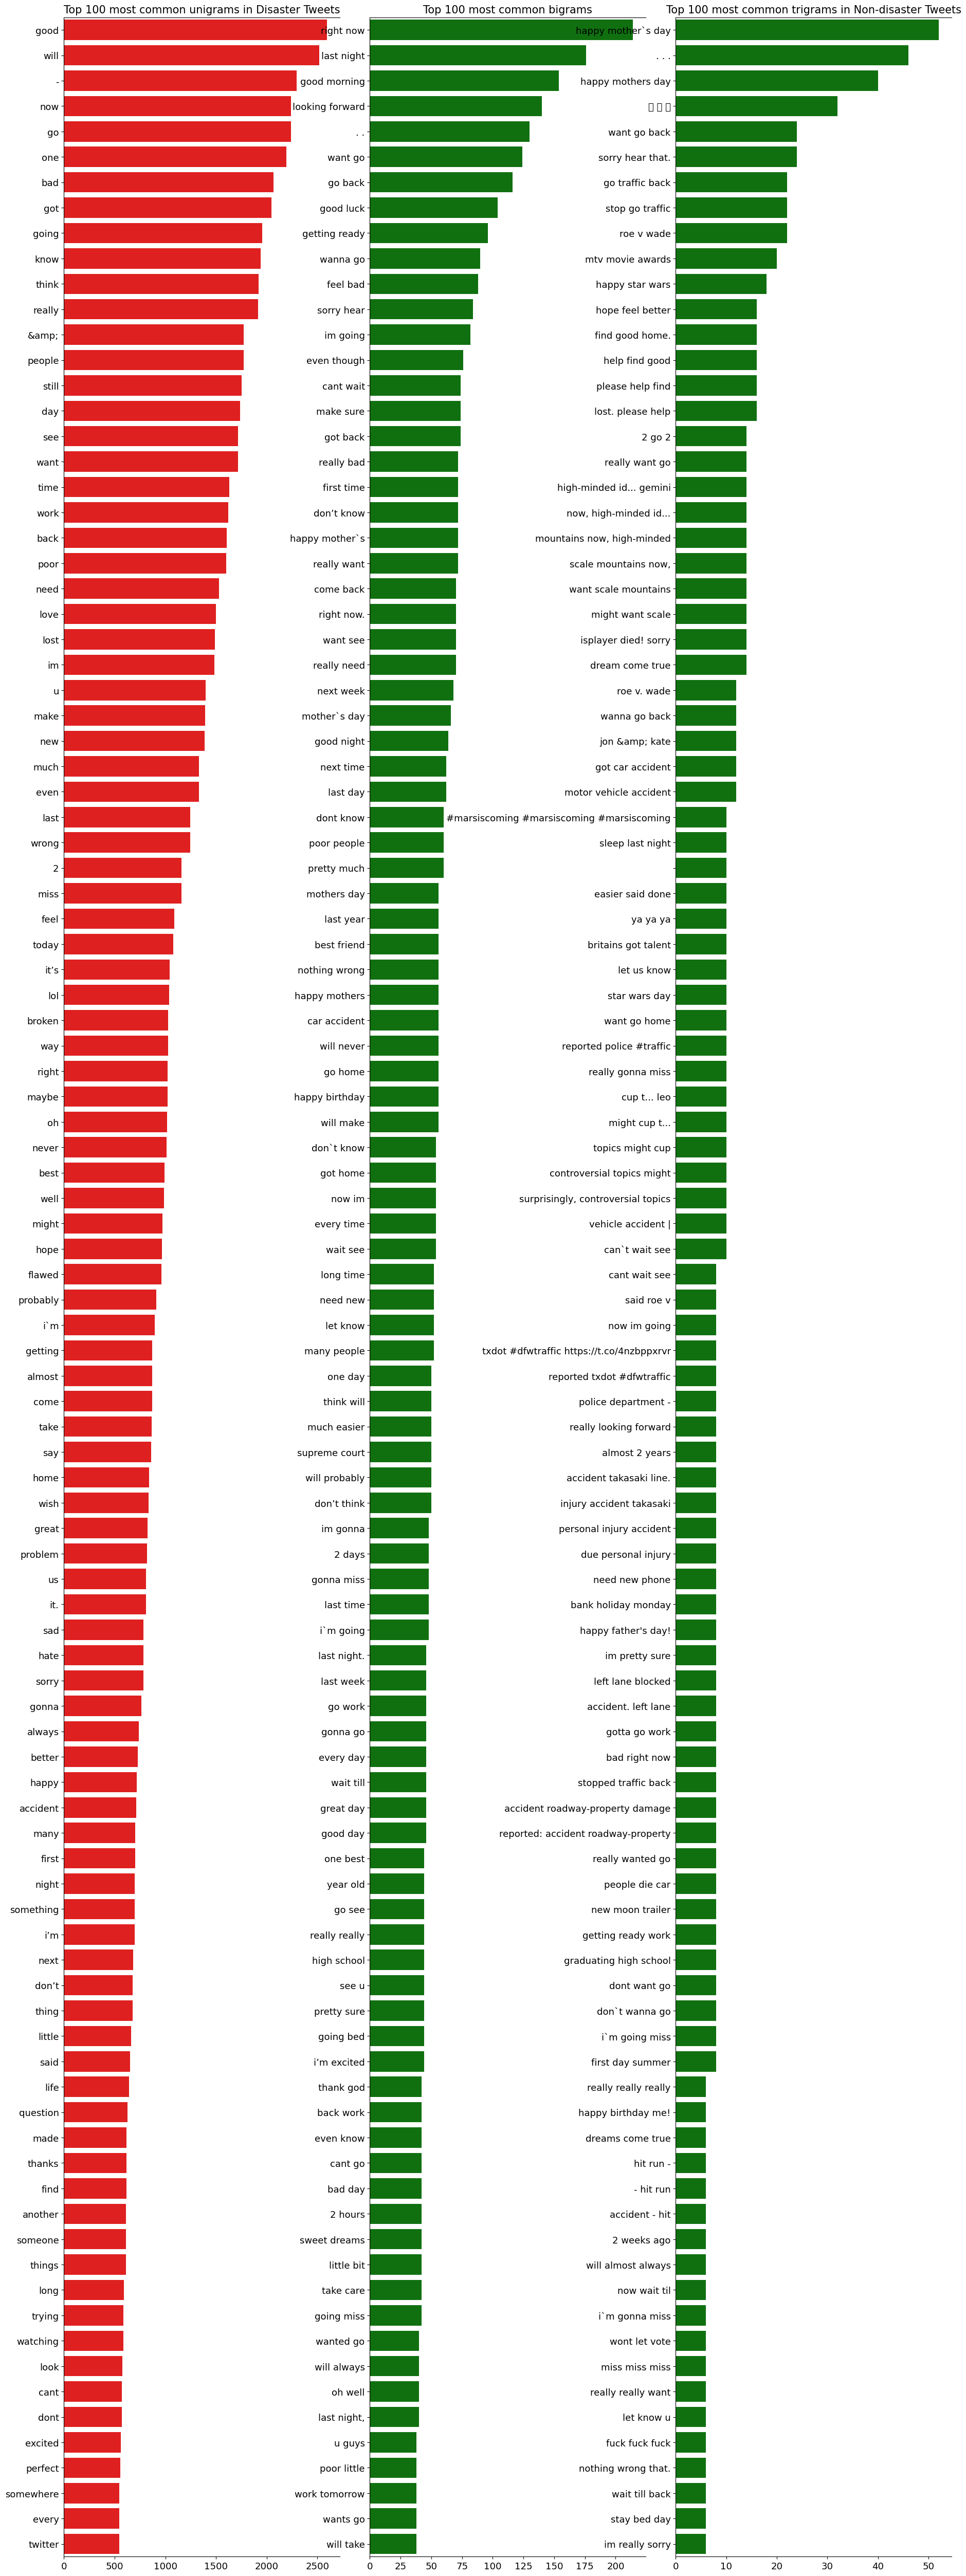

In [15]:
fig, axes = plt.subplots(ncols=3, figsize=(18, 50), dpi=100)
plt.tight_layout()

sns.barplot(y=unigrams[0].values[:N], x=unigrams[1].values[:N], ax=axes[0], color='red')
sns.barplot(y=bigrams[0].values[:N], x=bigrams[1].values[:N], ax=axes[1], color='green')
sns.barplot(y=trigrams[0].values[:N], x=trigrams[1].values[:N], ax=axes[2], color='green')

for i in range(3):
    axes[i].spines['right'].set_visible(False)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')
    axes[i].tick_params(axis='x', labelsize=13)
    axes[i].tick_params(axis='y', labelsize=13)

axes[0].set_title(f'Top {N} most common unigrams in Disaster Tweets', fontsize=15)
axes[1].set_title(f'Top {N} most common bigrams', fontsize=15)
axes[2].set_title(f'Top {N} most common trigrams in Non-disaster Tweets', fontsize=15)
plt.show()

## 텍스트 전처리  
- 전처리 코드 참조  
https://www.kaggle.com/code/gunesevitan/nlp-with-disaster-tweets-eda-cleaning-and-bert

In [16]:
def clean(text):

    # Special characters
    text = re.sub(r"\x89Û_", "", text)
    text = re.sub(r"\x89ÛÒ", "", text)
    text = re.sub(r"\x89ÛÓ", "", text)
    text = re.sub(r"\x89ÛÏWhen", "When", text)
    text = re.sub(r"\x89ÛÏ", "", text)
    text = re.sub(r"China\x89Ûªs", "China's", text)
    text = re.sub(r"let\x89Ûªs", "let's", text)
    text = re.sub(r"\x89Û÷", "", text)
    text = re.sub(r"\x89Ûª", "", text)
    text = re.sub(r"\x89Û\x9d", "", text)
    text = re.sub(r"å_", "", text)
    text = re.sub(r"\x89Û¢", "", text)
    text = re.sub(r"\x89Û¢åÊ", "", text)
    text = re.sub(r"fromåÊwounds", "from wounds", text)
    text = re.sub(r"åÊ", "", text)
    text = re.sub(r"åÈ", "", text)
    text = re.sub(r"JapÌ_n", "Japan", text)
    text = re.sub(r"Ì©", "e", text)
    text = re.sub(r"å¨", "", text)
    text = re.sub(r"SuruÌ¤", "Suruc", text)
    text = re.sub(r"åÇ", "", text)
    text = re.sub(r"å£3million", "3 million", text)
    text = re.sub(r"åÀ", "", text)

    # Contractions
    text = re.sub(r"he's", "he is", text)
    text = re.sub(r"there's", "there is", text)
    text = re.sub(r"We're", "We are", text)
    text = re.sub(r"That's", "That is", text)
    text = re.sub(r"won't", "will not", text)
    text = re.sub(r"they're", "they are", text)
    text = re.sub(r"Can't", "Cannot", text)
    text = re.sub(r"wasn't", "was not", text)
    text = re.sub(r"don\x89Ûªt", "do not", text)
    text = re.sub(r"aren't", "are not", text)
    text = re.sub(r"isn't", "is not", text)
    text = re.sub(r"What's", "What is", text)
    text = re.sub(r"haven't", "have not", text)
    text = re.sub(r"hasn't", "has not", text)
    text = re.sub(r"There's", "There is", text)
    text = re.sub(r"He's", "He is", text)
    text = re.sub(r"It's", "It is", text)
    text = re.sub(r"You're", "You are", text)
    text = re.sub(r"I'M", "I am", text)
    text = re.sub(r"shouldn't", "should not", text)
    text = re.sub(r"wouldn't", "would not", text)
    text = re.sub(r"i'm", "I am", text)
    text = re.sub(r"I\x89Ûªm", "I am", text)
    text = re.sub(r"I'm", "I am", text)
    text = re.sub(r"Isn't", "is not", text)
    text = re.sub(r"Here's", "Here is", text)
    text = re.sub(r"you've", "you have", text)
    text = re.sub(r"you\x89Ûªve", "you have", text)
    text = re.sub(r"we're", "we are", text)
    text = re.sub(r"what's", "what is", text)
    text = re.sub(r"couldn't", "could not", text)
    text = re.sub(r"we've", "we have", text)
    text = re.sub(r"it\x89Ûªs", "it is", text)
    text = re.sub(r"doesn\x89Ûªt", "does not", text)
    text = re.sub(r"It\x89Ûªs", "It is", text)
    text = re.sub(r"Here\x89Ûªs", "Here is", text)
    text = re.sub(r"who's", "who is", text)
    text = re.sub(r"I\x89Ûªve", "I have", text)
    text = re.sub(r"y'all", "you all", text)
    text = re.sub(r"can\x89Ûªt", "cannot", text)
    text = re.sub(r"would've", "would have", text)
    text = re.sub(r"it'll", "it will", text)
    text = re.sub(r"we'll", "we will", text)
    text = re.sub(r"wouldn\x89Ûªt", "would not", text)
    text = re.sub(r"We've", "We have", text)
    text = re.sub(r"he'll", "he will", text)
    text = re.sub(r"Y'all", "You all", text)
    text = re.sub(r"Weren't", "Were not", text)
    text = re.sub(r"Didn't", "Did not", text)
    text = re.sub(r"they'll", "they will", text)
    text = re.sub(r"they'd", "they would", text)
    text = re.sub(r"DON'T", "DO NOT", text)
    text = re.sub(r"That\x89Ûªs", "That is", text)
    text = re.sub(r"they've", "they have", text)
    text = re.sub(r"i'd", "I would", text)
    text = re.sub(r"should've", "should have", text)
    text = re.sub(r"You\x89Ûªre", "You are", text)
    text = re.sub(r"where's", "where is", text)
    text = re.sub(r"Don\x89Ûªt", "Do not", text)
    text = re.sub(r"we'd", "we would", text)
    text = re.sub(r"i'll", "I will", text)
    text = re.sub(r"weren't", "were not", text)
    text = re.sub(r"They're", "They are", text)
    text = re.sub(r"Can\x89Ûªt", "Cannot", text)
    text = re.sub(r"you\x89Ûªll", "you will", text)
    text = re.sub(r"I\x89Ûªd", "I would", text)
    text = re.sub(r"let's", "let us", text)
    text = re.sub(r"it's", "it is", text)
    text = re.sub(r"can't", "cannot", text)
    text = re.sub(r"don't", "do not", text)
    text = re.sub(r"you're", "you are", text)
    text = re.sub(r"i've", "I have", text)
    text = re.sub(r"that's", "that is", text)
    text = re.sub(r"i'll", "I will", text)
    text = re.sub(r"doesn't", "does not", text)
    text = re.sub(r"i'd", "I would", text)
    text = re.sub(r"didn't", "did not", text)
    text = re.sub(r"ain't", "am not", text)
    text = re.sub(r"you'll", "you will", text)
    text = re.sub(r"I've", "I have", text)
    text = re.sub(r"Don't", "do not", text)
    text = re.sub(r"I'll", "I will", text)
    text = re.sub(r"I'd", "I would", text)
    text = re.sub(r"Let's", "Let us", text)
    text = re.sub(r"you'd", "You would", text)
    text = re.sub(r"It's", "It is", text)
    text = re.sub(r"Ain't", "am not", text)
    text = re.sub(r"Haven't", "Have not", text)
    text = re.sub(r"Could've", "Could have", text)
    text = re.sub(r"youve", "you have", text)
    text = re.sub(r"donå«t", "do not", text)

    # Character entity references
    text = re.sub(r"&gt;", ">", text)
    text = re.sub(r"&lt;", "<", text)
    text = re.sub(r"&amp;", "&", text)

    # Typos, slang and informal abbreviations
    text = re.sub(r"w/e", "whatever", text)
    text = re.sub(r"w/", "with", text)
    text = re.sub(r"USAgov", "USA government", text)
    text = re.sub(r"recentlu", "recently", text)
    text = re.sub(r"Ph0tos", "Photos", text)
    text = re.sub(r"amirite", "am I right", text)
    text = re.sub(r"exp0sed", "exposed", text)
    text = re.sub(r"<3", "love", text)
    text = re.sub(r"amageddon", "armageddon", text)
    text = re.sub(r"Trfc", "Traffic", text)
    text = re.sub(r"8/5/2015", "2015-08-05", text)
    text = re.sub(r"WindStorm", "Wind Storm", text)
    text = re.sub(r"8/6/2015", "2015-08-06", text)
    text = re.sub(r"10:38PM", "10:38 PM", text)
    text = re.sub(r"10:30pm", "10:30 PM", text)
    text = re.sub(r"16yr", "16 year", text)
    text = re.sub(r"lmao", "laughing my ass off", text)
    text = re.sub(r"TRAUMATISED", "traumatized", text)

    # Hashtags and usernames
    text = re.sub(r"IranDeal", "Iran Deal", text)
    text = re.sub(r"ArianaGrande", "Ariana Grande", text)
    text = re.sub(r"camilacabello97", "camila cabello", text)
    text = re.sub(r"RondaRousey", "Ronda Rousey", text)
    text = re.sub(r"MTVHottest", "MTV Hottest", text)
    text = re.sub(r"TrapMusic", "Trap Music", text)
    text = re.sub(r"ProphetMuhammad", "Prophet Muhammad", text)
    text = re.sub(r"PantherAttack", "Panther Attack", text)
    text = re.sub(r"StrategicPatience", "Strategic Patience", text)
    text = re.sub(r"socialnews", "social news", text)
    text = re.sub(r"NASAHurricane", "NASA Hurricane", text)
    text = re.sub(r"onlinecommunities", "online communities", text)
    text = re.sub(r"humanconsumption", "human consumption", text)
    text = re.sub(r"Typhoon-Devastated", "Typhoon Devastated", text)
    text = re.sub(r"Meat-Loving", "Meat Loving", text)
    text = re.sub(r"facialabuse", "facial abuse", text)
    text = re.sub(r"LakeCounty", "Lake County", text)
    text = re.sub(r"BeingAuthor", "Being Author", text)
    text = re.sub(r"withheavenly", "with heavenly", text)
    text = re.sub(r"thankU", "thank you", text)
    text = re.sub(r"iTunesMusic", "iTunes Music", text)
    text = re.sub(r"OffensiveContent", "Offensive Content", text)
    text = re.sub(r"WorstSummerJob", "Worst Summer Job", text)
    text = re.sub(r"HarryBeCareful", "Harry Be Careful", text)
    text = re.sub(r"NASASolarSystem", "NASA Solar System", text)
    text = re.sub(r"animalrescue", "animal rescue", text)
    text = re.sub(r"KurtSchlichter", "Kurt Schlichter", text)
    text = re.sub(r"aRmageddon", "armageddon", text)
    text = re.sub(r"Throwingknifes", "Throwing knives", text)
    text = re.sub(r"GodsLove", "God's Love", text)
    text = re.sub(r"bookboost", "book boost", text)
    text = re.sub(r"ibooklove", "I book love", text)
    text = re.sub(r"NestleIndia", "Nestle India", text)
    text = re.sub(r"realDonaldTrump", "Donald Trump", text)
    text = re.sub(r"DavidVonderhaar", "David Vonderhaar", text)
    text = re.sub(r"CecilTheLion", "Cecil The Lion", text)
    text = re.sub(r"weathernetwork", "weather network", text)
    text = re.sub(r"withBioterrorism&use", "with Bioterrorism & use", text)
    text = re.sub(r"Hostage&2", "Hostage & 2", text)
    text = re.sub(r"GOPDebate", "GOP Debate", text)
    text = re.sub(r"RickPerry", "Rick Perry", text)
    text = re.sub(r"frontpage", "front page", text)
    text = re.sub(r"NewsIntexts", "News In texts", text)
    text = re.sub(r"ViralSpell", "Viral Spell", text)
    text = re.sub(r"til_now", "until now", text)
    text = re.sub(r"volcanoinRussia", "volcano in Russia", text)
    text = re.sub(r"ZippedNews", "Zipped News", text)
    text = re.sub(r"MicheleBachman", "Michele Bachman", text)
    text = re.sub(r"53inch", "53 inch", text)
    text = re.sub(r"KerrickTrial", "Kerrick Trial", text)
    text = re.sub(r"abstorm", "Alberta Storm", text)
    text = re.sub(r"Beyhive", "Beyonce hive", text)
    text = re.sub(r"IDFire", "Idaho Fire", text)
    text = re.sub(r"DETECTADO", "Detected", text)
    text = re.sub(r"RockyFire", "Rocky Fire", text)
    text = re.sub(r"Listen/Buy", "Listen / Buy", text)
    text = re.sub(r"NickCannon", "Nick Cannon", text)
    text = re.sub(r"FaroeIslands", "Faroe Islands", text)
    text = re.sub(r"yycstorm", "Calgary Storm", text)
    text = re.sub(r"IDPs:", "Internally Displaced People :", text)
    text = re.sub(r"ArtistsUnited", "Artists United", text)
    text = re.sub(r"ClaytonBryant", "Clayton Bryant", text)
    text = re.sub(r"jimmyfallon", "jimmy fallon", text)
    text = re.sub(r"justinbieber", "justin bieber", text)
    text = re.sub(r"UTC2015", "UTC 2015", text)
    text = re.sub(r"Time2015", "Time 2015", text)
    text = re.sub(r"djicemoon", "dj icemoon", text)
    text = re.sub(r"LivingSafely", "Living Safely", text)
    text = re.sub(r"FIFA16", "Fifa 2016", text)
    text = re.sub(r"thisiswhywecanthavenicethings", "this is why we cannot have nice things", text)
    text = re.sub(r"bbcnews", "bbc news", text)
    text = re.sub(r"UndergroundRailraod", "Underground Railraod", text)
    text = re.sub(r"c4news", "c4 news", text)
    text = re.sub(r"OBLITERATION", "obliteration", text)
    text = re.sub(r"MUDSLIDE", "mudslide", text)
    text = re.sub(r"NoSurrender", "No Surrender", text)
    text = re.sub(r"NotExplained", "Not Explained", text)
    text = re.sub(r"greatbritishbakeoff", "great british bake off", text)
    text = re.sub(r"LondonFire", "London Fire", text)
    text = re.sub(r"KOTAWeather", "KOTA Weather", text)
    text = re.sub(r"LuchaUnderground", "Lucha Underground", text)
    text = re.sub(r"KOIN6News", "KOIN 6 News", text)
    text = re.sub(r"LiveOnK2", "Live On K2", text)
    text = re.sub(r"9NewsGoldCoast", "9 News Gold Coast", text)
    text = re.sub(r"nikeplus", "nike plus", text)
    text = re.sub(r"david_cameron", "David Cameron", text)
    text = re.sub(r"peterjukes", "Peter Jukes", text)
    text = re.sub(r"JamesMelville", "James Melville", text)
    text = re.sub(r"megynkelly", "Megyn Kelly", text)
    text = re.sub(r"cnewslive", "C News Live", text)
    text = re.sub(r"JamaicaObserver", "Jamaica Observer", text)
    text = re.sub(r"textLikeItsSeptember11th2001", "text like it is september 11th 2001", text)
    text = re.sub(r"cbplawyers", "cbp lawyers", text)
    text = re.sub(r"fewmoretexts", "few more texts", text)
    text = re.sub(r"BlackLivesMatter", "Black Lives Matter", text)
    text = re.sub(r"cjoyner", "Chris Joyner", text)
    text = re.sub(r"ENGvAUS", "England vs Australia", text)
    text = re.sub(r"ScottWalker", "Scott Walker", text)
    text = re.sub(r"MikeParrActor", "Michael Parr", text)
    text = re.sub(r"4PlayThursdays", "Foreplay Thursdays", text)
    text = re.sub(r"TGF2015", "Tontitown Grape Festival", text)
    text = re.sub(r"realmandyrain", "Mandy Rain", text)
    text = re.sub(r"GraysonDolan", "Grayson Dolan", text)
    text = re.sub(r"ApolloBrown", "Apollo Brown", text)
    text = re.sub(r"saddlebrooke", "Saddlebrooke", text)
    text = re.sub(r"TontitownGrape", "Tontitown Grape", text)
    text = re.sub(r"AbbsWinston", "Abbs Winston", text)
    text = re.sub(r"ShaunKing", "Shaun King", text)
    text = re.sub(r"MeekMill", "Meek Mill", text)
    text = re.sub(r"TornadoGiveaway", "Tornado Giveaway", text)
    text = re.sub(r"GRupdates", "GR updates", text)
    text = re.sub(r"SouthDowns", "South Downs", text)
    text = re.sub(r"braininjury", "brain injury", text)
    text = re.sub(r"auspol", "Australian politics", text)
    text = re.sub(r"PlannedParenthood", "Planned Parenthood", text)
    text = re.sub(r"calgaryweather", "Calgary Weather", text)
    text = re.sub(r"weallheartonedirection", "we all heart one direction", text)
    text = re.sub(r"edsheeran", "Ed Sheeran", text)
    text = re.sub(r"TrueHeroes", "True Heroes", text)
    text = re.sub(r"S3XLEAK", "sex leak", text)
    text = re.sub(r"ComplexMag", "Complex Magazine", text)
    text = re.sub(r"TheAdvocateMag", "The Advocate Magazine", text)
    text = re.sub(r"CityofCalgary", "City of Calgary", text)
    text = re.sub(r"EbolaOutbreak", "Ebola Outbreak", text)
    text = re.sub(r"SummerFate", "Summer Fate", text)
    text = re.sub(r"RAmag", "Royal Academy Magazine", text)
    text = re.sub(r"offers2go", "offers to go", text)
    text = re.sub(r"foodscare", "food scare", text)
    text = re.sub(r"MNPDNashville", "Metropolitan Nashville Police Department", text)
    text = re.sub(r"TfLBusAlerts", "TfL Bus Alerts", text)
    text = re.sub(r"GamerGate", "Gamer Gate", text)
    text = re.sub(r"IHHen", "Humanitarian Relief", text)
    text = re.sub(r"spinningbot", "spinning bot", text)
    text = re.sub(r"ModiMinistry", "Modi Ministry", text)
    text = re.sub(r"TAXIWAYS", "taxi ways", text)
    text = re.sub(r"Calum5SOS", "Calum Hood", text)
    text = re.sub(r"po_st", "po.st", text)
    text = re.sub(r"scoopit", "scoop.it", text)
    text = re.sub(r"UltimaLucha", "Ultima Lucha", text)
    text = re.sub(r"JonathanFerrell", "Jonathan Ferrell", text)
    text = re.sub(r"aria_ahrary", "Aria Ahrary", text)
    text = re.sub(r"rapidcity", "Rapid City", text)
    text = re.sub(r"OutBid", "outbid", text)
    text = re.sub(r"lavenderpoetrycafe", "lavender poetry cafe", text)
    text = re.sub(r"EudryLantiqua", "Eudry Lantiqua", text)
    text = re.sub(r"15PM", "15 PM", text)
    text = re.sub(r"OriginalFunko", "Funko", text)
    text = re.sub(r"rightwaystan", "Richard Tan", text)
    text = re.sub(r"CindyNoonan", "Cindy Noonan", text)
    text = re.sub(r"RT_America", "RT America", text)
    text = re.sub(r"narendramodi", "Narendra Modi", text)
    text = re.sub(r"BakeOffFriends", "Bake Off Friends", text)
    text = re.sub(r"TeamHendrick", "Hendrick Motorsports", text)
    text = re.sub(r"alexbelloli", "Alex Belloli", text)
    text = re.sub(r"itsjustinstuart", "Justin Stuart", text)
    text = re.sub(r"gunsense", "gun sense", text)
    text = re.sub(r"DebateQuestionsWeWantToHear", "debate questions we want to hear", text)
    text = re.sub(r"RoyalCarribean", "Royal Carribean", text)
    text = re.sub(r"samanthaturne19", "Samantha Turner", text)
    text = re.sub(r"JonVoyage", "Jon Stewart", text)
    text = re.sub(r"renew911health", "renew 911 health", text)
    text = re.sub(r"SuryaRay", "Surya Ray", text)
    text = re.sub(r"pattonoswalt", "Patton Oswalt", text)
    text = re.sub(r"minhazmerchant", "Minhaz Merchant", text)
    text = re.sub(r"TLVFaces", "Israel Diaspora Coalition", text)
    text = re.sub(r"pmarca", "Marc Andreessen", text)
    text = re.sub(r"pdx911", "Portland Police", text)
    text = re.sub(r"jamaicaplain", "Jamaica Plain", text)
    text = re.sub(r"Japton", "Arkansas", text)
    text = re.sub(r"RouteComplex", "Route Complex", text)
    text = re.sub(r"INSubcontinent", "Indian Subcontinent", text)
    text = re.sub(r"NJTurnpike", "New Jersey Turnpike", text)
    text = re.sub(r"Politifiact", "PolitiFact", text)
    text = re.sub(r"Hiroshima70", "Hiroshima", text)
    text = re.sub(r"GMMBC", "Greater Mt Moriah Baptist Church", text)
    text = re.sub(r"versethe", "verse the", text)
    text = re.sub(r"TubeStrike", "Tube Strike", text)
    text = re.sub(r"MissionHills", "Mission Hills", text)
    text = re.sub(r"ProtectDenaliWolves", "Protect Denali Wolves", text)
    text = re.sub(r"NANKANA", "Nankana", text)
    text = re.sub(r"SAHIB", "Sahib", text)
    text = re.sub(r"PAKPATTAN", "Pakpattan", text)
    text = re.sub(r"Newz_Sacramento", "News Sacramento", text)
    text = re.sub(r"gofundme", "go fund me", text)
    text = re.sub(r"pmharper", "Stephen Harper", text)
    text = re.sub(r"IvanBerroa", "Ivan Berroa", text)
    text = re.sub(r"LosDelSonido", "Los Del Sonido", text)
    text = re.sub(r"bancodeseries", "banco de series", text)
    text = re.sub(r"timkaine", "Tim Kaine", text)
    text = re.sub(r"IdentityTheft", "Identity Theft", text)
    text = re.sub(r"AllLivesMatter", "All Lives Matter", text)
    text = re.sub(r"mishacollins", "Misha Collins", text)
    text = re.sub(r"BillNeelyNBC", "Bill Neely", text)
    text = re.sub(r"BeClearOnCancer", "be clear on cancer", text)
    text = re.sub(r"Kowing", "Knowing", text)
    text = re.sub(r"ScreamQueens", "Scream Queens", text)
    text = re.sub(r"AskCharley", "Ask Charley", text)
    text = re.sub(r"BlizzHeroes", "Heroes of the Storm", text)
    text = re.sub(r"BradleyBrad47", "Bradley Brad", text)
    text = re.sub(r"HannaPH", "Typhoon Hanna", text)
    text = re.sub(r"meinlcymbals", "MEINL Cymbals", text)
    text = re.sub(r"Ptbo", "Peterborough", text)
    text = re.sub(r"cnnbrk", "CNN Breaking News", text)
    text = re.sub(r"IndianNews", "Indian News", text)
    text = re.sub(r"savebees", "save bees", text)
    text = re.sub(r"GreenHarvard", "Green Harvard", text)
    text = re.sub(r"StandwithPP", "Stand with planned parenthood", text)
    text = re.sub(r"hermancranston", "Herman Cranston", text)
    text = re.sub(r"WMUR9", "WMUR-TV", text)
    text = re.sub(r"RockBottomRadFM", "Rock Bottom Radio", text)
    text = re.sub(r"ameenshaikh3", "Ameen Shaikh", text)
    text = re.sub(r"ProSyn", "Project Syndicate", text)
    text = re.sub(r"Daesh", "ISIS", text)
    text = re.sub(r"s2g", "swear to god", text)
    text = re.sub(r"listenlive", "listen live", text)
    text = re.sub(r"CDCgov", "Centers for Disease Control and Prevention", text)
    text = re.sub(r"FoxNew", "Fox News", text)
    text = re.sub(r"CBSBigBrother", "Big Brother", text)
    text = re.sub(r"JulieDiCaro", "Julie DiCaro", text)
    text = re.sub(r"theadvocatemag", "The Advocate Magazine", text)
    text = re.sub(r"RohnertParkDPS", "Rohnert Park Police Department", text)
    text = re.sub(r"THISIZBWRIGHT", "Bonnie Wright", text)
    text = re.sub(r"Popularmmos", "Popular MMOs", text)
    text = re.sub(r"WildHorses", "Wild Horses", text)
    text = re.sub(r"FantasticFour", "Fantastic Four", text)
    text = re.sub(r"HORNDALE", "Horndale", text)
    text = re.sub(r"PINER", "Piner", text)
    text = re.sub(r"BathAndNorthEastSomerset", "Bath and North East Somerset", text)
    text = re.sub(r"thatswhatfriendsarefor", "that is what friends are for", text)
    text = re.sub(r"residualincome", "residual income", text)
    text = re.sub(r"YahooNewsDigest", "Yahoo News Digest", text)
    text = re.sub(r"MalaysiaAirlines", "Malaysia Airlines", text)
    text = re.sub(r"AmazonDeals", "Amazon Deals", text)
    text = re.sub(r"MissCharleyWebb", "Charley Webb", text)
    text = re.sub(r"shoalstraffic", "shoals traffic", text)
    text = re.sub(r"GeorgeFoster72", "George Foster", text)
    text = re.sub(r"pop2015", "pop 2015", text)
    text = re.sub(r"_PokemonCards_", "Pokemon Cards", text)
    text = re.sub(r"DianneG", "Dianne Gallagher", text)
    text = re.sub(r"KashmirConflict", "Kashmir Conflict", text)
    text = re.sub(r"BritishBakeOff", "British Bake Off", text)
    text = re.sub(r"FreeKashmir", "Free Kashmir", text)
    text = re.sub(r"mattmosley", "Matt Mosley", text)
    text = re.sub(r"BishopFred", "Bishop Fred", text)
    text = re.sub(r"EndConflict", "End Conflict", text)
    text = re.sub(r"EndOccupation", "End Occupation", text)
    text = re.sub(r"UNHEALED", "unhealed", text)
    text = re.sub(r"CharlesDagnall", "Charles Dagnall", text)
    text = re.sub(r"Latestnews", "Latest news", text)
    text = re.sub(r"KindleCountdown", "Kindle Countdown", text)
    text = re.sub(r"NoMoreHandouts", "No More Handouts", text)
    text = re.sub(r"datingtips", "dating tips", text)
    text = re.sub(r"charlesadler", "Charles Adler", text)
    text = re.sub(r"twia", "Texas Windstorm Insurance Association", text)
    text = re.sub(r"txlege", "Texas Legislature", text)
    text = re.sub(r"WindstormInsurer", "Windstorm Insurer", text)
    text = re.sub(r"Newss", "News", text)
    text = re.sub(r"hempoil", "hemp oil", text)
    text = re.sub(r"CommoditiesAre", "Commodities are", text)
    text = re.sub(r"tubestrike", "tube strike", text)
    text = re.sub(r"JoeNBC", "Joe Scarborough", text)
    text = re.sub(r"LiteraryCakes", "Literary Cakes", text)
    text = re.sub(r"TI5", "The International 5", text)
    text = re.sub(r"thehill", "the hill", text)
    text = re.sub(r"3others", "3 others", text)
    text = re.sub(r"stighefootball", "Sam Tighe", text)
    text = re.sub(r"whatstheimportantvideo", "what is the important video", text)
    text = re.sub(r"ClaudioMeloni", "Claudio Meloni", text)
    text = re.sub(r"DukeSkywalker", "Duke Skywalker", text)
    text = re.sub(r"carsonmwr", "Fort Carson", text)
    text = re.sub(r"offdishduty", "off dish duty", text)
    text = re.sub(r"andword", "and word", text)
    text = re.sub(r"rhodeisland", "Rhode Island", text)
    text = re.sub(r"easternoregon", "Eastern Oregon", text)
    text = re.sub(r"WAwildfire", "Washington Wildfire", text)
    text = re.sub(r"fingerrockfire", "Finger Rock Fire", text)
    text = re.sub(r"57am", "57 am", text)
    text = re.sub(r"fingerrockfire", "Finger Rock Fire", text)
    text = re.sub(r"JacobHoggard", "Jacob Hoggard", text)
    text = re.sub(r"newnewnew", "new new new", text)
    text = re.sub(r"under50", "under 50", text)
    text = re.sub(r"getitbeforeitsgone", "get it before it is gone", text)
    text = re.sub(r"freshoutofthebox", "fresh out of the box", text)
    text = re.sub(r"amwriting", "am writing", text)
    text = re.sub(r"Bokoharm", "Boko Haram", text)
    text = re.sub(r"Nowlike", "Now like", text)
    text = re.sub(r"seasonfrom", "season from", text)
    text = re.sub(r"epicente", "epicenter", text)
    text = re.sub(r"epicenterr", "epicenter", text)
    text = re.sub(r"sicklife", "sick life", text)
    text = re.sub(r"yycweather", "Calgary Weather", text)
    text = re.sub(r"calgarysun", "Calgary Sun", text)
    text = re.sub(r"approachng", "approaching", text)
    text = re.sub(r"evng", "evening", text)
    text = re.sub(r"Sumthng", "something", text)
    text = re.sub(r"EllenPompeo", "Ellen Pompeo", text)
    text = re.sub(r"shondarhimes", "Shonda Rhimes", text)
    text = re.sub(r"ABCNetwork", "ABC Network", text)
    text = re.sub(r"SushmaSwaraj", "Sushma Swaraj", text)
    text = re.sub(r"pray4japan", "Pray for Japan", text)
    text = re.sub(r"hope4japan", "Hope for Japan", text)
    text = re.sub(r"Illusionimagess", "Illusion images", text)
    text = re.sub(r"SummerUnderTheStars", "Summer Under The Stars", text)
    text = re.sub(r"ShallWeDance", "Shall We Dance", text)
    text = re.sub(r"TCMParty", "TCM Party", text)
    text = re.sub(r"marijuananews", "marijuana news", text)
    text = re.sub(r"onbeingwithKristaTippett", "on being with Krista Tippett", text)
    text = re.sub(r"Beingtexts", "Being texts", text)
    text = re.sub(r"newauthors", "new authors", text)
    text = re.sub(r"remedyyyy", "remedy", text)
    text = re.sub(r"44PM", "44 PM", text)
    text = re.sub(r"HeadlinesApp", "Headlines App", text)
    text = re.sub(r"40PM", "40 PM", text)
    text = re.sub(r"myswc", "Severe Weather Center", text)
    text = re.sub(r"ithats", "that is", text)
    text = re.sub(r"icouldsitinthismomentforever", "I could sit in this moment forever", text)
    text = re.sub(r"FatLoss", "Fat Loss", text)
    text = re.sub(r"02PM", "02 PM", text)
    text = re.sub(r"MetroFmTalk", "Metro Fm Talk", text)
    text = re.sub(r"Bstrd", "bastard", text)
    text = re.sub(r"bldy", "bloody", text)
    text = re.sub(r"MetrofmTalk", "Metro Fm Talk", text)
    text = re.sub(r"terrorismturn", "terrorism turn", text)
    text = re.sub(r"BBCNewsAsia", "BBC News Asia", text)
    text = re.sub(r"BehindTheScenes", "Behind The Scenes", text)
    text = re.sub(r"GeorgeTakei", "George Takei", text)
    text = re.sub(r"WomensWeeklyMag", "Womens Weekly Magazine", text)
    text = re.sub(r"SurvivorsGuidetoEarth", "Survivors Guide to Earth", text)
    text = re.sub(r"incubusband", "incubus band", text)
    text = re.sub(r"Babypicturethis", "Baby picture this", text)
    text = re.sub(r"BombEffects", "Bomb Effects", text)
    text = re.sub(r"win10", "Windows 10", text)
    text = re.sub(r"idkidk", "I do not know I do not know", text)
    text = re.sub(r"TheWalkingDead", "The Walking Dead", text)
    text = re.sub(r"amyschumer", "Amy Schumer", text)
    text = re.sub(r"crewlist", "crew list", text)
    text = re.sub(r"Erdogans", "Erdogan", text)
    text = re.sub(r"BBCLive", "BBC Live", text)
    text = re.sub(r"TonyAbbottMHR", "Tony Abbott", text)
    text = re.sub(r"paulmyerscough", "Paul Myerscough", text)
    text = re.sub(r"georgegallagher", "George Gallagher", text)
    text = re.sub(r"JimmieJohnson", "Jimmie Johnson", text)
    text = re.sub(r"pctool", "pc tool", text)
    text = re.sub(r"DoingHashtagsRight", "Doing Hashtags Right", text)
    text = re.sub(r"ThrowbackThursday", "Throwback Thursday", text)
    text = re.sub(r"SnowBackSunday", "Snowback Sunday", text)
    text = re.sub(r"LakeEffect", "Lake Effect", text)
    text = re.sub(r"RTphotographyUK", "Richard Thomas Photography UK", text)
    text = re.sub(r"BigBang_CBS", "Big Bang CBS", text)
    text = re.sub(r"writerslife", "writers life", text)
    text = re.sub(r"NaturalBirth", "Natural Birth", text)
    text = re.sub(r"UnusualWords", "Unusual Words", text)
    text = re.sub(r"wizkhalifa", "Wiz Khalifa", text)
    text = re.sub(r"acreativedc", "a creative DC", text)
    text = re.sub(r"vscodc", "vsco DC", text)
    text = re.sub(r"VSCOcam", "vsco camera", text)
    text = re.sub(r"TheBEACHDC", "The beach DC", text)
    text = re.sub(r"buildingmuseum", "building museum", text)
    text = re.sub(r"WorldOil", "World Oil", text)
    text = re.sub(r"redwedding", "red wedding", text)
    text = re.sub(r"AmazingRaceCanada", "Amazing Race Canada", text)
    text = re.sub(r"WakeUpAmerica", "Wake Up America", text)
    text = re.sub(r"\\Allahuakbar\\", "Allahu Akbar", text)
    text = re.sub(r"bleased", "blessed", text)
    text = re.sub(r"nigeriantribune", "Nigerian Tribune", text)
    text = re.sub(r"HIDEO_KOJIMA_EN", "Hideo Kojima", text)
    text = re.sub(r"FusionFestival", "Fusion Festival", text)
    text = re.sub(r"50Mixed", "50 Mixed", text)
    text = re.sub(r"NoAgenda", "No Agenda", text)
    text = re.sub(r"WhiteGenocide", "White Genocide", text)
    text = re.sub(r"dirtylying", "dirty lying", text)
    text = re.sub(r"SyrianRefugees", "Syrian Refugees", text)
    text = re.sub(r"changetheworld", "change the world", text)
    text = re.sub(r"Ebolacase", "Ebola case", text)
    text = re.sub(r"mcgtech", "mcg technologies", text)
    text = re.sub(r"withweapons", "with weapons", text)
    text = re.sub(r"advancedwarfare", "advanced warfare", text)
    text = re.sub(r"letsFootball", "let us Football", text)
    text = re.sub(r"LateNiteMix", "late night mix", text)
    text = re.sub(r"PhilCollinsFeed", "Phil Collins", text)
    text = re.sub(r"RudyHavenstein", "Rudy Havenstein", text)
    text = re.sub(r"22PM", "22 PM", text)
    text = re.sub(r"54am", "54 AM", text)
    text = re.sub(r"38am", "38 AM", text)
    text = re.sub(r"OldFolkExplainStuff", "Old Folk Explain Stuff", text)
    text = re.sub(r"BlacklivesMatter", "Black Lives Matter", text)
    text = re.sub(r"InsaneLimits", "Insane Limits", text)
    text = re.sub(r"youcantsitwithus", "you cannot sit with us", text)
    text = re.sub(r"2k15", "2015", text)
    text = re.sub(r"TheIran", "Iran", text)
    text = re.sub(r"JimmyFallon", "Jimmy Fallon", text)
    text = re.sub(r"AlbertBrooks", "Albert Brooks", text)
    text = re.sub(r"defense_news", "defense news", text)
    text = re.sub(r"nuclearrcSA", "Nuclear Risk Control Self Assessment", text)
    text = re.sub(r"Auspol", "Australia Politics", text)
    text = re.sub(r"NuclearPower", "Nuclear Power", text)
    text = re.sub(r"WhiteTerrorism", "White Terrorism", text)
    text = re.sub(r"truthfrequencyradio", "Truth Frequency Radio", text)
    text = re.sub(r"ErasureIsNotEquality", "Erasure is not equality", text)
    text = re.sub(r"ProBonoNews", "Pro Bono News", text)
    text = re.sub(r"JakartaPost", "Jakarta Post", text)
    text = re.sub(r"toopainful", "too painful", text)
    text = re.sub(r"melindahaunton", "Melinda Haunton", text)
    text = re.sub(r"NoNukes", "No Nukes", text)
    text = re.sub(r"curryspcworld", "Currys PC World", text)
    text = re.sub(r"ineedcake", "I need cake", text)
    text = re.sub(r"blackforestgateau", "black forest gateau", text)
    text = re.sub(r"BBCOne", "BBC One", text)
    text = re.sub(r"AlexxPage", "Alex Page", text)
    text = re.sub(r"jonathanserrie", "Jonathan Serrie", text)
    text = re.sub(r"SocialJerkBlog", "Social Jerk Blog", text)
    text = re.sub(r"ChelseaVPeretti", "Chelsea Peretti", text)
    text = re.sub(r"irongiant", "iron giant", text)
    text = re.sub(r"RonFunches", "Ron Funches", text)
    text = re.sub(r"TimCook", "Tim Cook", text)
    text = re.sub(r"sebastianstanisaliveandwell", "Sebastian Stan is alive and well", text)
    text = re.sub(r"Madsummer", "Mad summer", text)
    text = re.sub(r"NowYouKnow", "Now you know", text)
    text = re.sub(r"concertphotography", "concert photography", text)
    text = re.sub(r"TomLandry", "Tom Landry", text)
    text = re.sub(r"showgirldayoff", "show girl day off", text)
    text = re.sub(r"Yougslavia", "Yugoslavia", text)
    text = re.sub(r"QuantumDataInformatics", "Quantum Data Informatics", text)
    text = re.sub(r"FromTheDesk", "From The Desk", text)
    text = re.sub(r"TheaterTrial", "Theater Trial", text)
    text = re.sub(r"CatoInstitute", "Cato Institute", text)
    text = re.sub(r"EmekaGift", "Emeka Gift", text)
    text = re.sub(r"LetsBe_Rational", "Let us be rational", text)
    text = re.sub(r"Cynicalreality", "Cynical reality", text)
    text = re.sub(r"FredOlsenCruise", "Fred Olsen Cruise", text)
    text = re.sub(r"NotSorry", "not sorry", text)
    text = re.sub(r"UseYourWords", "use your words", text)
    text = re.sub(r"WordoftheDay", "word of the day", text)
    text = re.sub(r"Dictionarycom", "Dictionary.com", text)
    text = re.sub(r"TheBrooklynLife", "The Brooklyn Life", text)
    text = re.sub(r"jokethey", "joke they", text)
    text = re.sub(r"nflweek1picks", "NFL week 1 picks", text)
    text = re.sub(r"uiseful", "useful", text)
    text = re.sub(r"JusticeDotOrg", "The American Association for Justice", text)
    text = re.sub(r"autoaccidents", "auto accidents", text)
    text = re.sub(r"SteveGursten", "Steve Gursten", text)
    text = re.sub(r"MichiganAutoLaw", "Michigan Auto Law", text)
    text = re.sub(r"birdgang", "bird gang", text)
    text = re.sub(r"nflnetwork", "NFL Network", text)
    text = re.sub(r"NYDNSports", "NY Daily News Sports", text)
    text = re.sub(r"RVacchianoNYDN", "Ralph Vacchiano NY Daily News", text)
    text = re.sub(r"EdmontonEsks", "Edmonton Eskimos", text)
    text = re.sub(r"david_brelsford", "David Brelsford", text)
    text = re.sub(r"TOI_India", "The Times of India", text)
    text = re.sub(r"hegot", "he got", text)
    text = re.sub(r"SkinsOn9", "Skins on 9", text)
    text = re.sub(r"sothathappened", "so that happened", text)
    text = re.sub(r"LCOutOfDoors", "LC Out Of Doors", text)
    text = re.sub(r"NationFirst", "Nation First", text)
    text = re.sub(r"IndiaToday", "India Today", text)
    text = re.sub(r"HLPS", "helps", text)
    text = re.sub(r"HOSTAGESTHROSW", "hostages throw", text)
    text = re.sub(r"SNCTIONS", "sanctions", text)
    text = re.sub(r"BidTime", "Bid Time", text)
    text = re.sub(r"crunchysensible", "crunchy sensible", text)
    text = re.sub(r"RandomActsOfRomance", "Random acts of romance", text)
    text = re.sub(r"MomentsAtHill", "Moments at hill", text)
    text = re.sub(r"eatshit", "eat shit", text)
    text = re.sub(r"liveleakfun", "live leak fun", text)
    text = re.sub(r"SahelNews", "Sahel News", text)
    text = re.sub(r"abc7newsbayarea", "ABC 7 News Bay Area", text)
    text = re.sub(r"facilitiesmanagement", "facilities management", text)
    text = re.sub(r"facilitydude", "facility dude", text)
    text = re.sub(r"CampLogistics", "Camp logistics", text)
    text = re.sub(r"alaskapublic", "Alaska public", text)
    text = re.sub(r"MarketResearch", "Market Research", text)
    text = re.sub(r"AccuracyEsports", "Accuracy Esports", text)
    text = re.sub(r"TheBodyShopAust", "The Body Shop Australia", text)
    text = re.sub(r"yychail", "Calgary hail", text)
    text = re.sub(r"yyctraffic", "Calgary traffic", text)
    text = re.sub(r"eliotschool", "eliot school", text)
    text = re.sub(r"TheBrokenCity", "The Broken City", text)
    text = re.sub(r"OldsFireDept", "Olds Fire Department", text)
    text = re.sub(r"RiverComplex", "River Complex", text)
    text = re.sub(r"fieldworksmells", "field work smells", text)
    text = re.sub(r"IranElection", "Iran Election", text)
    text = re.sub(r"glowng", "glowing", text)
    text = re.sub(r"kindlng", "kindling", text)
    text = re.sub(r"riggd", "rigged", text)
    text = re.sub(r"slownewsday", "slow news day", text)
    text = re.sub(r"MyanmarFlood", "Myanmar Flood", text)
    text = re.sub(r"abc7chicago", "ABC 7 Chicago", text)
    text = re.sub(r"copolitics", "Colorado Politics", text)
    text = re.sub(r"AdilGhumro", "Adil Ghumro", text)
    text = re.sub(r"netbots", "net bots", text)
    text = re.sub(r"byebyeroad", "bye bye road", text)
    text = re.sub(r"massiveflooding", "massive flooding", text)
    text = re.sub(r"EndofUS", "End of United States", text)
    text = re.sub(r"35PM", "35 PM", text)
    text = re.sub(r"greektheatrela", "Greek Theatre Los Angeles", text)
    text = re.sub(r"76mins", "76 minutes", text)
    text = re.sub(r"publicsafetyfirst", "public safety first", text)
    text = re.sub(r"livesmatter", "lives matter", text)
    text = re.sub(r"myhometown", "my hometown", text)
    text = re.sub(r"tankerfire", "tanker fire", text)
    text = re.sub(r"MEMORIALDAY", "memorial day", text)
    text = re.sub(r"MEMORIAL_DAY", "memorial day", text)
    text = re.sub(r"instaxbooty", "instagram booty", text)
    text = re.sub(r"Jerusalem_Post", "Jerusalem Post", text)
    text = re.sub(r"WayneRooney_INA", "Wayne Rooney", text)
    text = re.sub(r"VirtualReality", "Virtual Reality", text)
    text = re.sub(r"OculusRift", "Oculus Rift", text)
    text = re.sub(r"OwenJones84", "Owen Jones", text)
    text = re.sub(r"jeremycorbyn", "Jeremy Corbyn", text)
    text = re.sub(r"paulrogers002", "Paul Rogers", text)
    text = re.sub(r"mortalkombatx", "Mortal Kombat X", text)
    text = re.sub(r"mortalkombat", "Mortal Kombat", text)
    text = re.sub(r"FilipeCoelho92", "Filipe Coelho", text)
    text = re.sub(r"OnlyQuakeNews", "Only Quake News", text)
    text = re.sub(r"kostumes", "costumes", text)
    text = re.sub(r"YEEESSSS", "yes", text)
    text = re.sub(r"ToshikazuKatayama", "Toshikazu Katayama", text)
    text = re.sub(r"IntlDevelopment", "Intl Development", text)
    text = re.sub(r"ExtremeWeather", "Extreme Weather", text)
    text = re.sub(r"WereNotGruberVoters", "We are not gruber voters", text)
    text = re.sub(r"NewsThousands", "News Thousands", text)
    text = re.sub(r"EdmundAdamus", "Edmund Adamus", text)
    text = re.sub(r"EyewitnessWV", "Eye witness WV", text)
    text = re.sub(r"PhiladelphiaMuseu", "Philadelphia Museum", text)
    text = re.sub(r"DublinComicCon", "Dublin Comic Con", text)
    text = re.sub(r"NicholasBrendon", "Nicholas Brendon", text)
    text = re.sub(r"Alltheway80s", "All the way 80s", text)
    text = re.sub(r"FromTheField", "From the field", text)
    text = re.sub(r"NorthIowa", "North Iowa", text)
    text = re.sub(r"WillowFire", "Willow Fire", text)
    text = re.sub(r"MadRiverComplex", "Mad River Complex", text)
    text = re.sub(r"feelingmanly", "feeling manly", text)
    text = re.sub(r"stillnotoverit", "still not over it", text)
    text = re.sub(r"FortitudeValley", "Fortitude Valley", text)
    text = re.sub(r"CoastpowerlineTramTr", "Coast powerline", text)
    text = re.sub(r"ServicesGold", "Services Gold", text)
    text = re.sub(r"NewsbrokenEmergency", "News broken emergency", text)
    text = re.sub(r"Evaucation", "evacuation", text)
    text = re.sub(r"leaveevacuateexitbe", "leave evacuate exit be", text)
    text = re.sub(r"P_EOPLE", "PEOPLE", text)
    text = re.sub(r"Tubestrike", "tube strike", text)
    text = re.sub(r"CLASS_SICK", "CLASS SICK", text)
    text = re.sub(r"localplumber", "local plumber", text)
    text = re.sub(r"awesomejobsiri", "awesome job siri", text)
    text = re.sub(r"PayForItHow", "Pay for it how", text)
    text = re.sub(r"ThisIsAfrica", "This is Africa", text)
    text = re.sub(r"crimeairnetwork", "crime air network", text)
    text = re.sub(r"KimAcheson", "Kim Acheson", text)
    text = re.sub(r"cityofcalgary", "City of Calgary", text)
    text = re.sub(r"prosyndicate", "pro syndicate", text)
    text = re.sub(r"660NEWS", "660 NEWS", text)
    text = re.sub(r"BusInsMagazine", "Business Insurance Magazine", text)
    text = re.sub(r"wfocus", "focus", text)
    text = re.sub(r"ShastaDam", "Shasta Dam", text)
    text = re.sub(r"go2MarkFranco", "Mark Franco", text)
    text = re.sub(r"StephGHinojosa", "Steph Hinojosa", text)
    text = re.sub(r"Nashgrier", "Nash Grier", text)
    text = re.sub(r"NashNewVideo", "Nash new video", text)
    text = re.sub(r"IWouldntGetElectedBecause", "I would not get elected because", text)
    text = re.sub(r"SHGames", "Sledgehammer Games", text)
    text = re.sub(r"bedhair", "bed hair", text)
    text = re.sub(r"JoelHeyman", "Joel Heyman", text)
    text = re.sub(r"viaYouTube", "via YouTube", text)
    text = re.sub(r"see u", "see you", text)
    text = re.sub(r"u guys", "you guys", text)
    text = re.sub(r"roe v wade", "roe versus wade", text)

    # Remove Urls
    text = re.sub(r"https?:\/\/t.co\/[A-Za-z0-9]+", "", text)

    # Words with punctuations and special characters
    punctuations = '@#!?+&*[]-%.:/();$=><|{}^' + "'`"
    for p in punctuations:
        text = text.replace(p, f' {p} ')

    # ... and ..
    text = text.replace('...', ' ... ')
    if '...' not in text:
        text = text.replace('..', ' ... ')

    # Acronyms
    text = re.sub(r"MH370", "Malaysia Airlines Flight 370", text)
    text = re.sub(r"mÌ¼sica", "music", text)
    text = re.sub(r"okwx", "Oklahoma City Weather", text)
    text = re.sub(r"arwx", "Arkansas Weather", text)
    text = re.sub(r"gawx", "Georgia Weather", text)
    text = re.sub(r"scwx", "South Carolina Weather", text)
    text = re.sub(r"cawx", "California Weather", text)
    text = re.sub(r"tnwx", "Tennessee Weather", text)
    text = re.sub(r"azwx", "Arizona Weather", text)
    text = re.sub(r"alwx", "Alabama Weather", text)
    text = re.sub(r"wordpressdotcom", "wordpress", text)
    text = re.sub(r"usNWSgov", "United States National Weather Service", text)
    text = re.sub(r"Suruc", "Sanliurfa", text)

    # Grouping same words without embeddings
    text = re.sub(r"Bestnaijamade", "bestnaijamade", text)
    text = re.sub(r"SOUDELOR", "Soudelor", text)

    return text

In [17]:
def text_preprocessing(df):
    df['text'] = df['text'].apply(lambda s : clean(s))
    
    return df

In [18]:
train_data.head()

,id,text,sentiment,sentiment_str,label
0,TRAIN_26100,Moms was lost in New York https://t.co/xxzN4AM5ZV,2,negative,0
1,TRAIN_18650,"@iChenchiah @AriLamm Sorry, poor choice of lan...",2,negative,0
2,TRAIN_21517,@chiccraftychick I am surprised I won since I ...,1,positive,2
3,TRAIN_06799,@Kaldruen I “Might” get back into SFV cause th...,0,neutral,1
4,TRAIN_31381,@AdorablePodcast @FemmeVoilet @GreenGuerilla1 ...,2,negative,0


In [19]:
train_data = text_preprocessing(train_data)
valid_data = text_preprocessing(valid_data)
test_data = text_preprocessing(test_data)

In [20]:
train_data.head()

,id,text,sentiment,sentiment_str,label
0,TRAIN_26100,Moms was lost in New York,2,negative,0
1,TRAIN_18650,"@ iChenchiah @ AriLamm Sorry, poor choice of...",2,negative,0
2,TRAIN_21517,@ chiccraftychick I am surprised I won since ...,1,positive,2
3,TRAIN_06799,@ Kaldruen I “Might” get back into SFV cause ...,0,neutral,1
4,TRAIN_31381,@ AdorablePodcast @ FemmeVoilet @ GreenGuer...,2,negative,0


## Model
- Pretrained Model : Bertweet-large
- BERTweet is trained based on the RoBERTa pre-training procedure. The corpus used to pre-train BERTweet consists of 850M English Tweets
- https://huggingface.co/vinai/bertweet-large

In [21]:
MODEL = "vinai/bertweet-large"

In [22]:
# PT
tokenizer = AutoTokenizer.from_pretrained(MODEL, use_fast=True, low_cpu_mem_usage=False)
model = AutoModelForSequenceClassification.from_pretrained(MODEL, num_labels=3)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/bertweet-large and are newly initialized: ['classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight', 'classifier.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## 토크나이저 이모지 처리 여부 확인

In [23]:
import emoji

emoji_list = list(emoji.UNICODE_EMOJI.keys())
cnt = 0
for e in emoji_list:
    tokenized = tokenizer.decode(tokenizer.encode(e)).strip("</s>").strip()
    if e not in tokenized:
        cnt += 1
print(f"{cnt/len(emoji_list)} of the emojis are not identified by this tokenizer.")

0.0 of the emojis are not identified by this tokenizer.


## 토크 나이징 최대 길이 체크

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


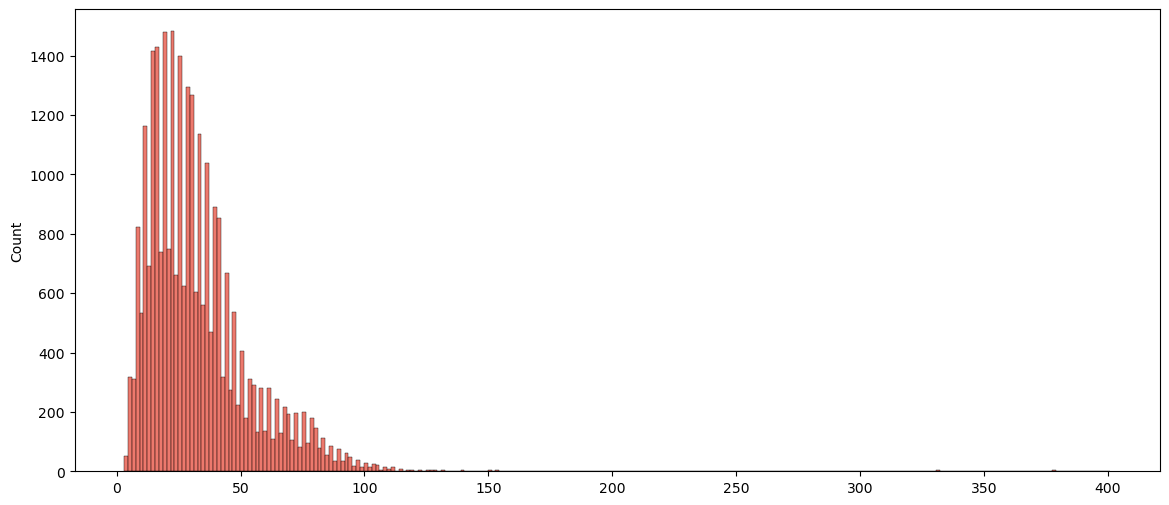

401


In [24]:
# Displaying sentence length dist.
token_lens = []

for text in train_data['text']:
    tokens = tokenizer.encode(text, max_length = 512)
    token_lens.append(len(tokens))

fig, axes = plt.subplots(figsize=(14, 6))
sns.histplot(token_lens, color='#e74c3c')
plt.show()
print(max(token_lens))

*Base Model 0:Negative 1: Neutral 2: Postive*

In [25]:
MAX_LEN = max(token_lens)

## 불필요 열삭제 및 토크나이징 후 데이터셋으로 변환

In [26]:
# 'sentiment_str' 열 삭제
train_data.drop(['id', 'sentiment', 'sentiment_str'], axis=1, inplace=True)
valid_data.drop(['id', 'sentiment', 'sentiment_str'], axis=1, inplace=True)
test_data.drop(['id'], axis=1, inplace=True)

In [27]:
train_dataset = Dataset.from_pandas(train_data)
valid_dataset = Dataset.from_pandas(valid_data)
test_dataset = Dataset.from_pandas(test_data)

In [28]:
def preprocess_function(examples):
    return tokenizer(examples["text"], truncation=True, max_length=MAX_LEN, padding="max_length")

train_dataset = train_dataset.map(preprocess_function, batched=True)
valid_dataset = valid_dataset.map(preprocess_function, batched=True)
test_dataset = test_dataset.map(preprocess_function, batched=True)

print(train_dataset)
print(valid_dataset)
print(test_dataset)

Map:   0%|          | 0/28800 [00:00<?, ? examples/s]

Map:   0%|          | 0/3200 [00:00<?, ? examples/s]

Map:   0%|          | 0/48000 [00:00<?, ? examples/s]

Dataset({
    features: ['text', 'label', 'input_ids', 'attention_mask'],
    num_rows: 28800
})
Dataset({
    features: ['text', 'label', 'input_ids', 'attention_mask'],
    num_rows: 3200
})
Dataset({
    features: ['text', 'input_ids', 'attention_mask'],
    num_rows: 48000
})


## F1 metric

In [29]:
metric = evaluate.load('f1') 

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels, average='macro')

## Train Arguments

In [30]:
training_args = TrainingArguments(
    do_eval=True,
    evaluation_strategy='steps',
    output_dir='test_trainer',
    logging_dir='test_trainer',
    logging_strategy='steps',
    save_strategy='steps',
    num_train_epochs=5,
    warmup_steps=50,
    learning_rate=1e-05,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    load_best_model_at_end=True,
    metric_for_best_model='f1',
    save_total_limit=1,
    fp16=True,
    weight_decay=0.1,
    seed=33,
    report_to="none"
)

In [31]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=valid_dataset,
    compute_metrics=compute_metrics,
    callbacks = [EarlyStoppingCallback(early_stopping_patience=3)],
)

In [32]:
trainer.train()

Step,Training Loss,Validation Loss,F1
500,0.807900,0.700783,0.547499
1000,0.484500,0.372508,0.809499
1500,0.377600,0.322706,0.844327
2000,0.322100,0.359424,0.852363
2500,0.287700,0.343667,0.848375
3000,0.271500,0.313367,0.847791
3500,0.269000,0.326615,0.856333
4000,0.209700,0.445800,0.851761
4500,0.204600,0.448621,0.847496
5000,0.194000,0.397495,0.853395


TrainOutput(global_step=5000, training_loss=0.3428787734985352, metrics={'train_runtime': 3527.2694, 'train_samples_per_second': 40.825, 'train_steps_per_second': 2.552, 'total_flos': 5.839152177552e+16, 'train_loss': 0.3428787734985352, 'epoch': 2.78})

## Save Model

In [33]:
trainer.save_model()

## Inference

In [34]:
predict_model = AutoModelForSequenceClassification.from_pretrained("test_trainer", num_labels=3)

In [35]:
predict_trainer = Trainer(
    model=predict_model
)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [36]:
prediction = predict_trainer.predict(test_dataset)
logits = prediction.predictions
soft_prob = softmax(logits)
print(soft_prob)

[[3.6567588e-08 2.3208811e-05 1.5320541e-07]
 [6.8481473e-05 1.1687704e-08 6.7455424e-08]
 [3.4757004e-08 2.0432589e-08 2.6713180e-05]
 ...
 [1.9929246e-05 8.9089189e-09 2.4530016e-07]
 [3.0197405e-08 1.5599842e-07 6.7805845e-06]
 [2.4297563e-07 4.8553388e-06 1.1045752e-07]]


In [37]:
max_class_indices = np.argmax(soft_prob, axis=1).reshape(-1, 1)
print(max_class_indices)

[[1]
 [0]
 [2]
 ...
 [0]
 [2]
 [1]]


## 정답 라벨로 예측라벨 변환
0: negative  1: neutral  2: positive

In [38]:
##sentiment labeling##
# 0: negative

# 1: neutral

# 2: positive

In [39]:
id2label = {0:"negative", 1:"neutral", 2:"positive"}

In [40]:
result = [id2label[idx] for idx in max_class_indices.flatten()]

In [41]:
SUBMIT_SENTIMENT_DICT = {'neutral': 0, 'positive': 1, 'negative': 2}

result = np.array(result)

def map_emotion(emotion):
    return SUBMIT_SENTIMENT_DICT[emotion]

result = np.vectorize(map_emotion)(result)
print(result)

[0 2 1 ... 2 1 0]


In [42]:
submit = pd.read_csv(SUBMIT)
preds = result
submit['sentiment'] = preds
submit.head()

,id,sentiment
0,TEST_00000,0
1,TEST_00001,2
2,TEST_00002,1
3,TEST_00003,0
4,TEST_00004,2


In [43]:
submit.to_csv('./bert_tweet_final.csv', index=False)